In [51]:
from pyspark import SparkContext
from pyspark.sql import HiveContext
from igraph import *
%matplotlib inline

In [52]:
from pyspark.sql.functions import sum, col, when, count

In [53]:
sc.stop()

In [54]:
sc = SparkContext(appName="product_id_friends")
datarun = HiveContext(sc)

In [66]:
data_voice = datarun.sql("select * from bigdata_hackathon_2017.voice_traffic_final_sample_rank where product_id = '1009213'").cache()

In [103]:
data_voice = \
data_voice.select(col("product_id").cast("String"), \
                  col("other_party_product_id").cast("String"), \
                  "duration")

In [104]:
edges = \
data_voice.select(col("product_id").alias("src"),col("other_party_product_id").alias("dst"),"duration") \
          .groupBy("src","dst") \
          .agg(count("*").alias("cnt"))

In [107]:
edges.show(100)

+-------+-------+---+
|    src|    dst|cnt|
+-------+-------+---+
|1009213|2792886|  2|
|1009213|2517360|  1|
|1009213|2553296| 25|
|1009213|1665968|  1|
|1009213|2870538|  2|
|1009213|2315645|  7|
|1009213|2559212|  1|
+-------+-------+---+



In [122]:
vertices = \
edges.select("src") \
     .unionAll(edges.select("dst")) \
     .withColumnRenamed("src","id") \
     .withColumn("color",when(col("id") == '1009213',0).otherwise(1)) \
     .distinct()

In [123]:
vertices.show(100)

+-------+-----+
|     id|color|
+-------+-----+
|2553296|    1|
|2315645|    1|
|2792886|    1|
|2517360|    1|
|1009213|    0|
|2559212|    1|
|2870538|    1|
|1665968|    1|
+-------+-----+



In [124]:
g = Graph()

In [125]:
vertices_pandas = vertices.toPandas()
g.add_vertices(vertices_pandas.shape[0])
g.vs['name'] = vertices_pandas['id']
g.vs['color'] = vertices_pandas['color']

In [126]:
edges_pandas = edges.toPandas()
g.add_edges(zip(edges_pandas['src'].values, edges_pandas['dst'].values))
g.es['cnt'] = edges_pandas['cnt'].values

In [127]:
g.summary()

'IGRAPH UN-- 8 7 -- \n+ attr: color (v), name (v), cnt (e)'

In [128]:
style = {}
style["margin"] = 75
style["vertex_label"] = g.vs["name"]
style["vertex_label_dist"] = 2
style["vertex_label_angle"] = 180
color_dict = {int("0"): "green", int("-1"):"red", int("1"):"blue"}
style["vertex_color"] = [color_dict[color] for color in g.vs["color"]]
style["edge_width"] = [int(x)/1.5 for x in g.es["cnt"]]
style["edge_curved"] = 0.2
style["edge_color"] = "gray"

In [131]:
plot(g, target="/home/jnovotny/notebooks/product_id_friends.png", **style)

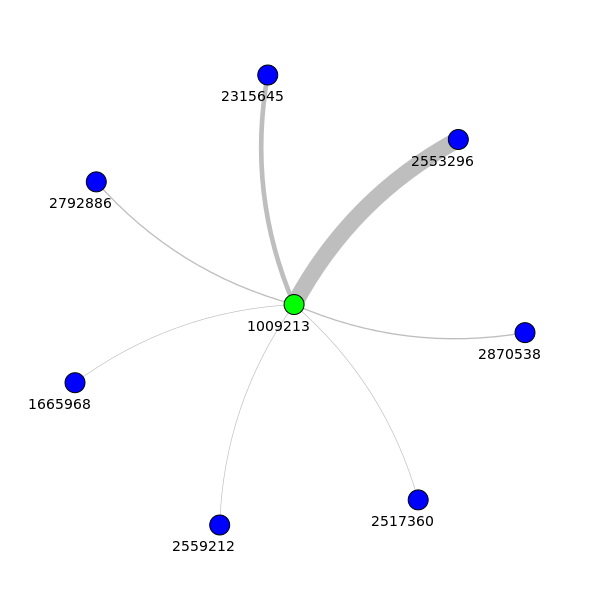

In [132]:
from IPython.display import Image
Image(filename='/home/jnovotny/notebooks/product_id_friends.png') 